#Hypothesis

I belive the most optimal time to make money in the market is during market open, and market close. During the first hour, and last hour of the day, I believe market volatility to be at its daily high, excluding extraordinary intraday events that cause certain securities to have increased volatility.

Lunch hour is an exception to this rule because of the daily schedule of many institutional day traders that close their positions to go eat lunch. As a result, there is the potiential for inefficiencies in the market during these hours: 

__11:00 CST - 13:00 CST__ (CST for Central Standard Time (US & Canada))

##Note After 03/31/17

Futures have been added to the Quantopian Research environment. Because of this addition, we will also be testing for the same data and inefficiencies we are testing on equities.

##Pre-Experimental Observations

####Market Open
I personally believe that the first 30 minutes of the market being open is where most of the money is made as a day trader. Not as many intraday swings happen as much as they do in the morning, because I believe that people are trying to get in on the hype, and ride the momentum of stocks up until they are satisfied with their day trades. Very rarely do I ever see volume follow the price trend in market open. It's very volatile, and a very risky time to trade at.

####Lunch Hour
I have noticed that intraday volume drops during this time period on the most actively traded securities during those hours. I have also noticed that during this time, securities move in a range of plus-minus __0.5%__ at most. 

There are times where the price trend follows the trend of the volume. This situation is very favorable, and can be detected early on with decent accuracy (hopefully)!

With enough capital, the inefficiency in the market can be taken advantage of, and as a result, net us a positive return with low beta, if proper risk management is in place.

####Market Close
In the last 5 minutes of the market before close, I have observed that the volume is indicative of the direction in which the market trends towards before it closes. Therefore, I propose that volume is a very useful indicator for the pre-market close. 

The volume's momentum is an indicator that usually either follows the price trend line at market close, or inverses it. This is another inefficiency (maybe) that could be harnessed to increase our returns. At most, I would expect price swings of __1.00%__ at the most (only in high volatility scenarios). There are some moments in which the price trend follows the volume trend, but goes out of sync (i.e., price is inverse of volume trend, then price begins to follow the volume trend within 5 minutes of market close)

#Market Open Analysis

###Procedure

1. Check if there's any correlations between volume, volatility, and starting prices from the beginning of the day to the previous
2. Analyze if correlations between massive upticks in price within the first minute of market open, and 10 minutes afterwards exist


In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import alphalens


import quantopian as q

from quantopian.research import run_pipeline
from quantopian.pipeline import Pipeline

from quantopian.pipeline.data.builtin import USEquityPricing
from quantopian.pipeline.filters import Q500US, Q1500US

sns.set()

In [12]:
def reshape_pricing_data_for_factor_analysis(pricing_factor_df, factor_name='factor'):
    multi = multi = pd.MultiIndex.from_product(
        [
            list(pricing_factor_df.index), list(pricing_factor_df.columns)
        ]
    )
    return pd.DataFrame(
        {
            factor_name: [
                entry for idx in pricing_factor_df.index for entry in pricing_factor_df.loc[idx]
            ]
        }, index=multi)

In [20]:
pl = lambda: Pipeline(screen=Q500US())

starting_date = '2017-12-01'
ending_date = '2017-12-21'
freq = 'minute'

equities = run_pipeline(pl(), 
                        start_date=starting_date, 
                        end_date=ending_date).index.levels[1]

daily_prices = get_pricing(equities, 
                           start_date=starting_date,
                           end_date=ending_date,
                           frequency=freq, 
                           fields='open_price')

intraday_volume = get_pricing(equities,
                              start_date=starting_date,
                              end_date=ending_date,
                              frequency=freq,
                              fields='volume')

In [21]:
pct_df = daily_prices.pct_change().fillna(method='ffill')#.dropna()
vol_pct = intraday_volume.pct_change().fillna(method='ffill')

In [22]:
open_volatility = daily_prices.rolling(window=5).std()
vol_vol = intraday_volume.rolling(window=2).std()
vol_pct_vol = vol_pct.rolling(window=2).std()

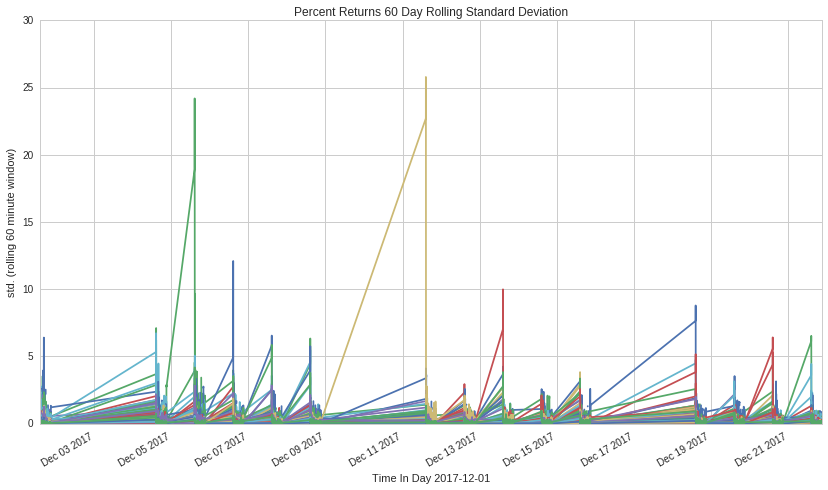

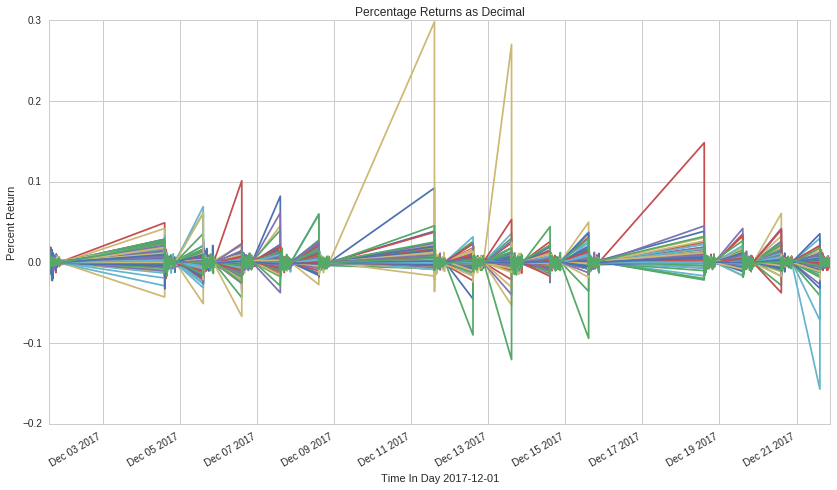

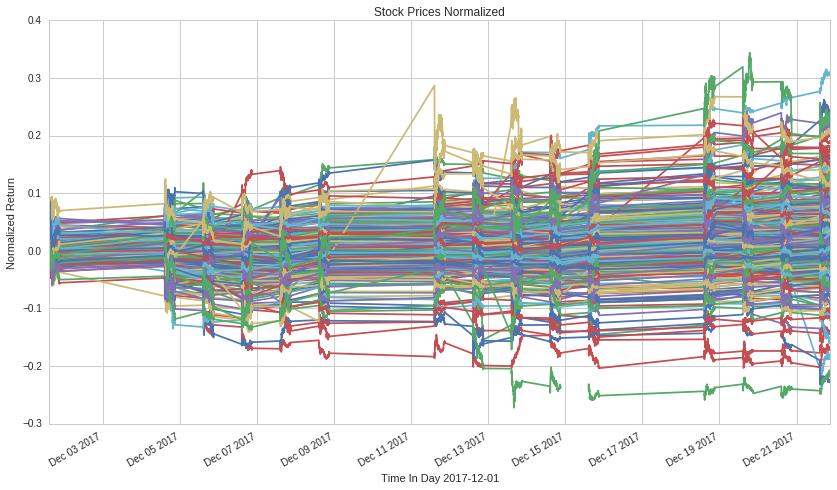

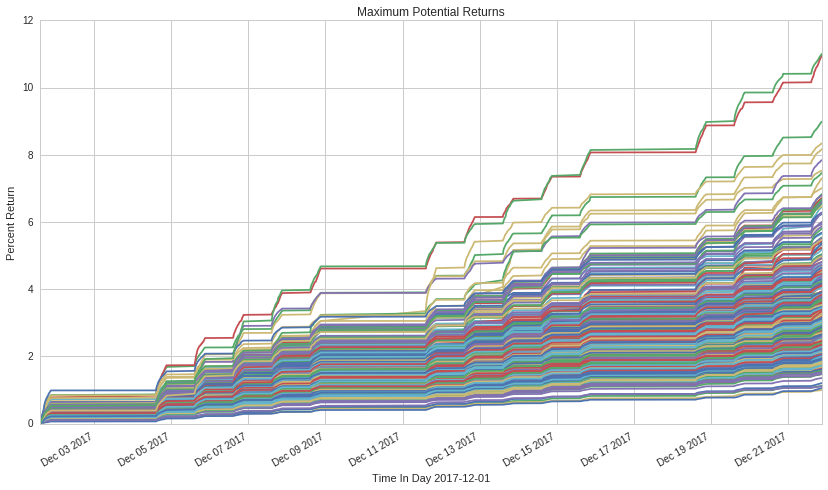

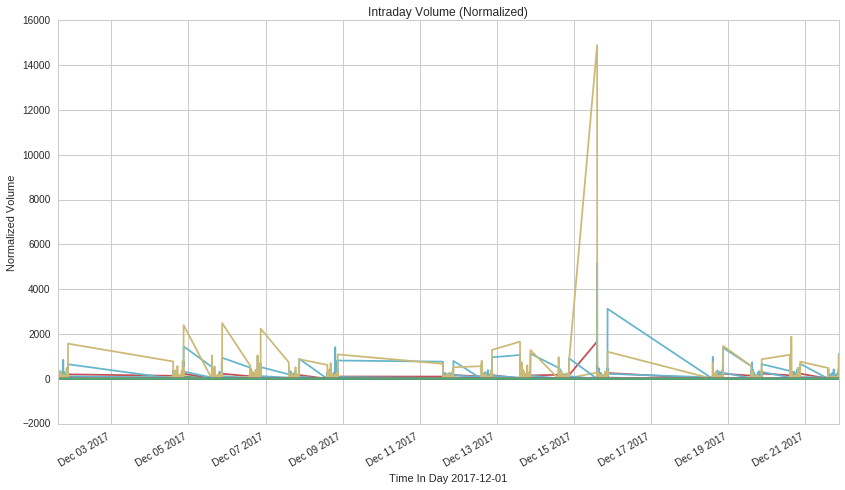

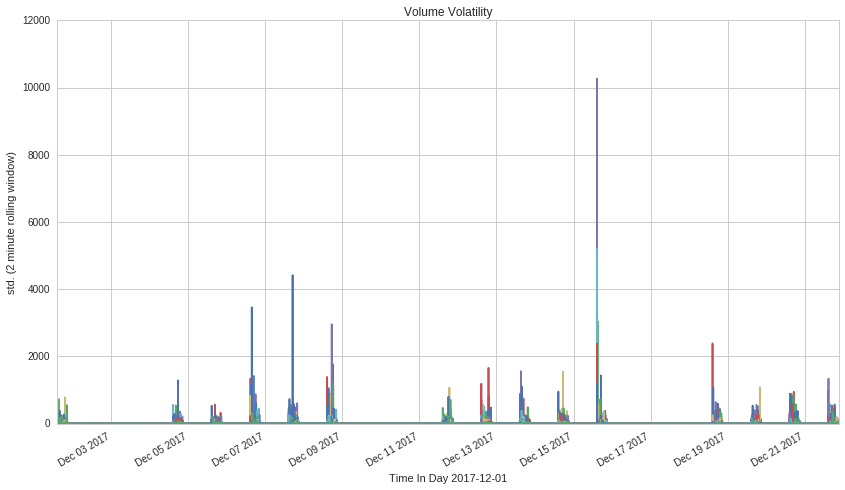

In [23]:
open_volatility.plot(legend=False)
plt.title('Percent Returns 60 Day Rolling Standard Deviation')
plt.xlabel('Time In Day %s' % starting_date)
plt.ylabel('std. (rolling 60 minute window)')

pct_df.plot(legend=False)
plt.title('Percentage Returns as Decimal')
plt.xlabel('Time In Day %s' % starting_date)
plt.ylabel('Percent Return')

daily_prices.div(daily_prices.iloc[0]).sub(1).plot(legend=False)
plt.title('Stock Prices Normalized')
plt.xlabel('Time In Day %s' % starting_date)
plt.ylabel('Normalized Return')

pct_df.abs().cumsum().plot(legend=False)
plt.title('Maximum Potential Returns')
plt.xlabel('Time In Day %s' % starting_date)
plt.ylabel('Percent Return')

intraday_volume.div(intraday_volume.iloc[0]).sub(1).plot(legend=False)
plt.title('Intraday Volume (Normalized)')
plt.xlabel('Time In Day %s' % starting_date)
plt.ylabel('Normalized Volume')

vol_pct_vol.plot(legend=False)
plt.title('Volume Volatility')
plt.xlabel('Time In Day %s' % starting_date)
plt.ylabel('std. (2 minute rolling window)')

In [24]:
formatted = reshape_pricing_data_for_factor_analysis(vol_pct_vol).dropna()
formatted.replace([np.inf, -np.inf], np.nan).dropna(inplace=True)

In [25]:
factor_fw_ret = alphalens.utils.get_clean_factor_and_forward_returns(formatted['factor'], prices=daily_prices, quantiles=10, periods=(5,10,60,120,240,300))

Quantiles Statistics


,min,max,mean,std,count,count %
factor_quantile,,,,,,
1,0.000000,0.656001,0.066227,0.044964,229160,10.110663
2,0.007379,1.069871,0.204999,0.062825,226357,9.986993
3,0.075031,1.284382,0.356262,0.088055,225831,9.963786
4,0.107583,2.365870,0.532098,0.122628,226374,9.987743
5,0.143907,3.890082,0.748897,0.172061,226949,10.013113
6,0.187651,5.300067,1.035056,0.245235,225239,9.937666
7,0.237497,7.649540,1.449585,0.367140,225824,9.963477
8,0.304622,79.228973,2.141675,0.683553,226381,9.988052
9,0.387391,673.573406,3.676203,4.851573,225807,9.962727


Returns Analysis


,5,10,60,120,240,300
Ann. alpha,0.000,-0.000,-0.000,-0.000,-0.000,-0.000
beta,-0.010,-0.025,-0.026,0.006,0.017,0.019
Mean Period Wise Return Top Quantile (bps),0.068,-0.038,-0.406,-0.409,-0.262,-0.739
Mean Period Wise Return Bottom Quantile (bps),0.006,-0.001,0.132,0.131,0.375,0.460
Mean Period Wise Spread (bps),0.013,-0.003,-0.008,-0.004,-0.002,-0.004


Information Analysis


,5,10,60,120,240,300
IC Mean,0.001,-0.000,-0.002,-0.002,-0.002,-0.003
IC Std.,0.056,0.055,0.056,0.055,0.054,0.053
t-stat(IC),1.691,-0.135,-3.222,-2.685,-2.630,-3.721
p-value(IC),0.091,0.892,0.001,0.007,0.009,0.000
IC Skew,-0.029,-0.039,0.005,0.005,-0.036,-0.027
IC Kurtosis,-0.016,0.087,-0.055,0.098,0.049,0.036
Ann. IR,0.360,-0.029,-0.687,-0.572,-0.560,-0.793


Turnover Analysis


,5,10,60,120,240,300
Quantile 1 Mean Turnover,0.906,0.907,0.906,0.908,0.907,0.910
Quantile 2 Mean Turnover,0.902,0.905,0.902,0.904,0.906,0.906
Quantile 3 Mean Turnover,0.903,0.905,0.903,0.905,0.906,0.907
Quantile 4 Mean Turnover,0.904,0.906,0.903,0.905,0.906,0.906
Quantile 5 Mean Turnover,0.906,0.906,0.904,0.906,0.906,0.907
Quantile 6 Mean Turnover,0.907,0.907,0.907,0.907,0.909,0.909
Quantile 7 Mean Turnover,0.908,0.909,0.908,0.910,0.910,0.911
Quantile 8 Mean Turnover,0.908,0.910,0.908,0.910,0.909,0.912
Quantile 9 Mean Turnover,0.903,0.906,0.905,0.907,0.908,0.910
Quantile 10 Mean Turnover,0.879,0.885,0.885,0.891,0.894,0.895


,5,10,60,120,240,300
Mean Factor Rank Autocorrelation,0.056,0.053,0.046,0.041,0.04,0.038


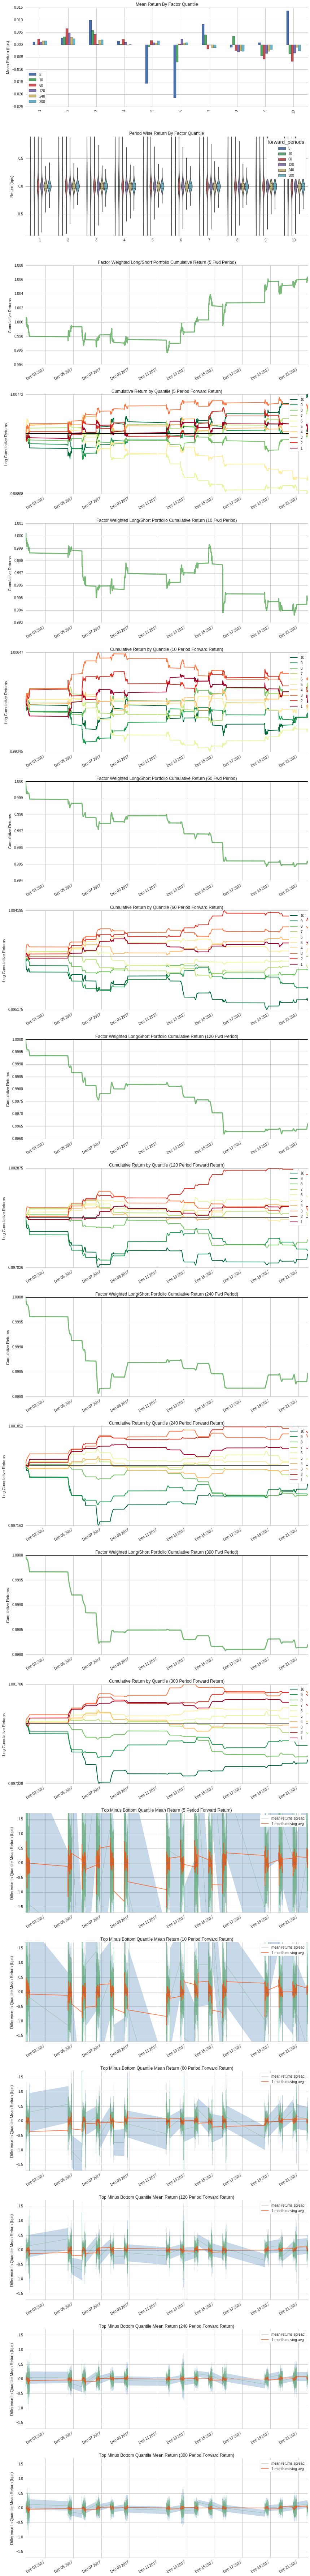

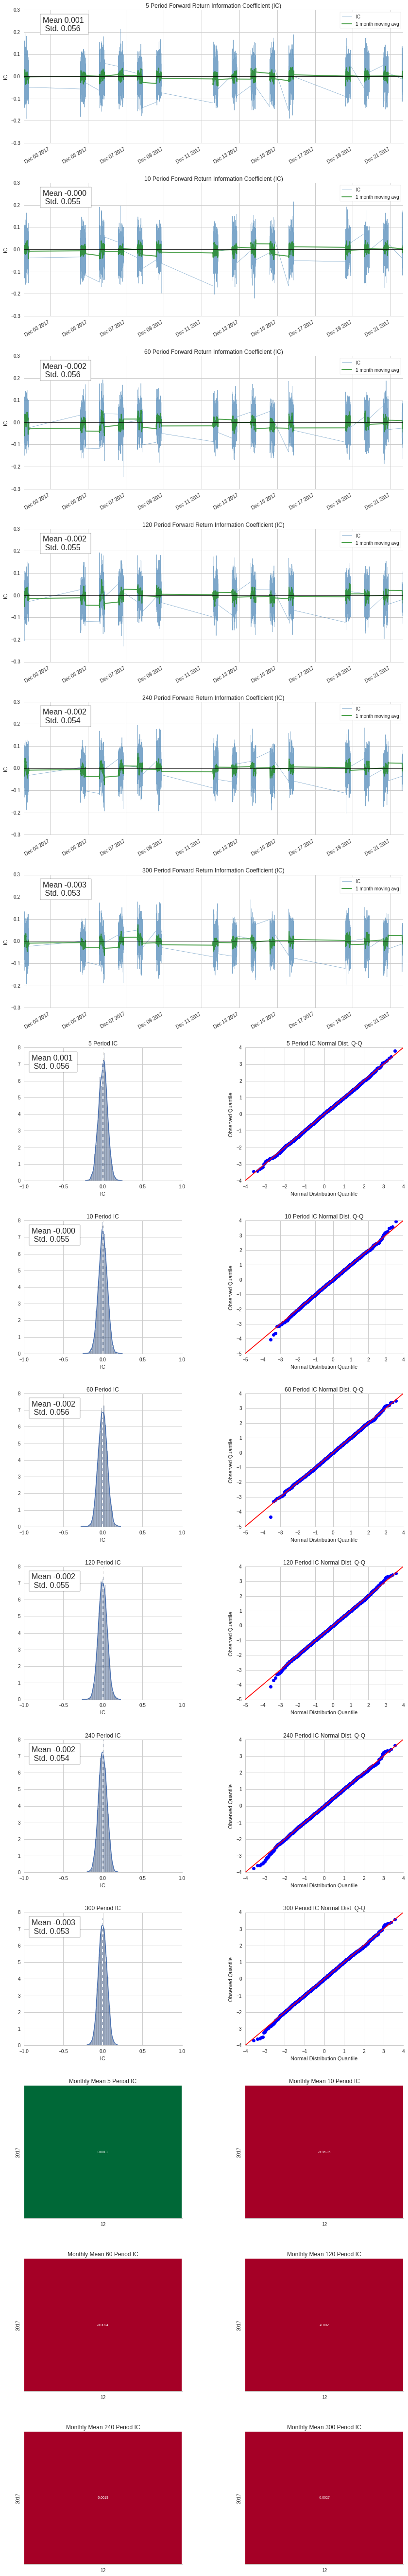

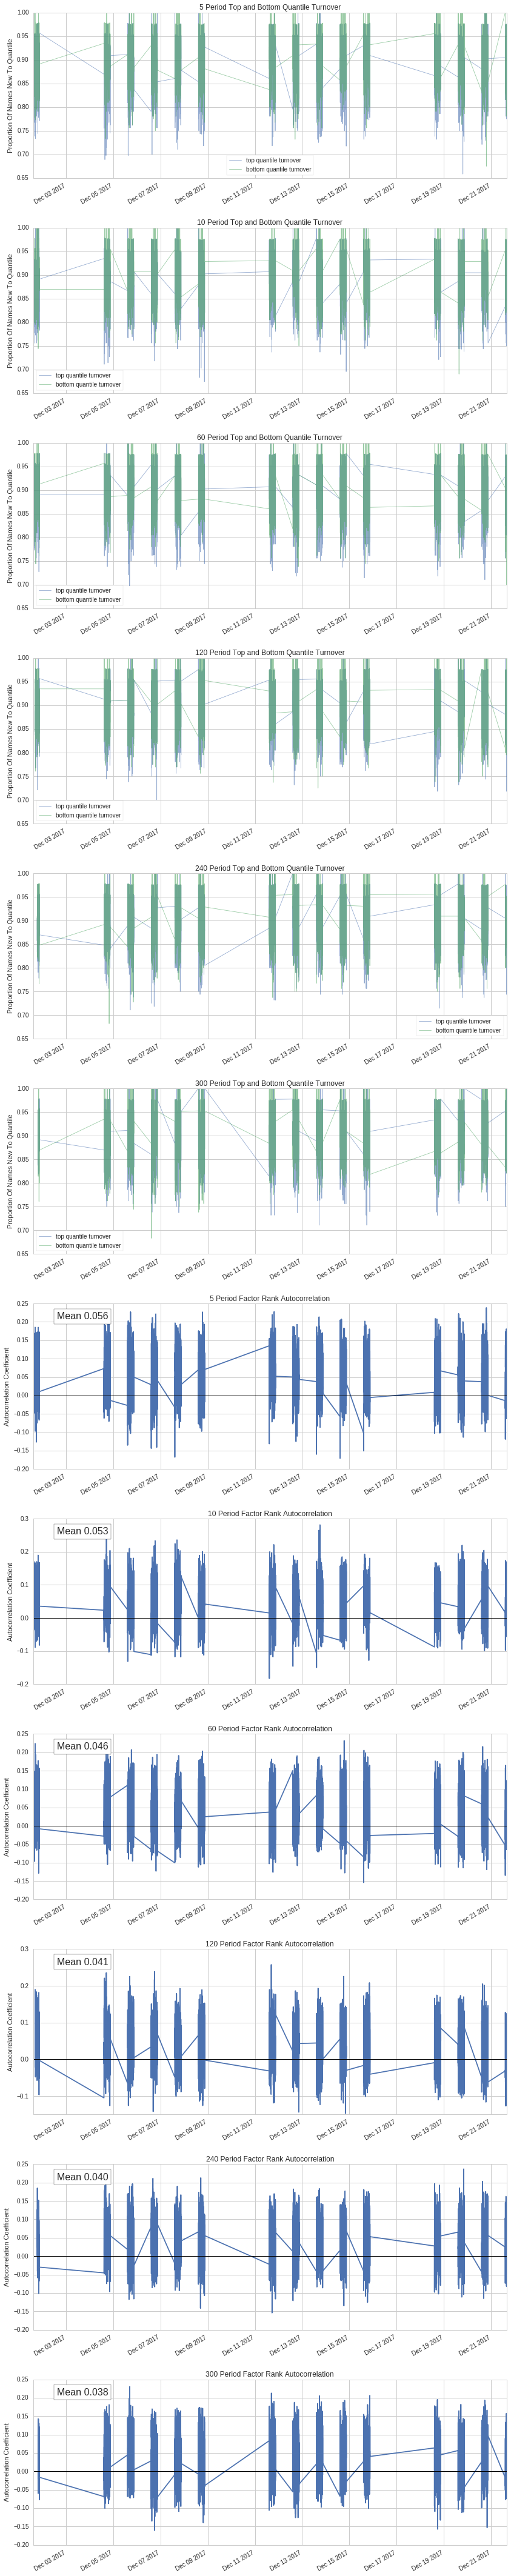

In [28]:
alphalens.tears.create_full_tear_sheet(factor_fw_ret)
#alphalens.performance.factor_returns(factor_fw_ret).plot()